<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-знакомство-с-данными" data-toc-modified-id="Загрузка-и-знакомство-с-данными-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и знакомство с данными</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Добавление-новых-признаков" data-toc-modified-id="Добавление-новых-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Добавление новых признаков</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверка-модели" data-toc-modified-id="Проверка-модели-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка модели</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Сначала устанавливаю и загружаю все необходимые для работы библиотеки

In [1]:
!pip install lightgbm -q
!pip install catboost -q
!pip install shap -q
!pip install phik -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 3.1 MB/s eta 0:00:00


In [2]:
!pip install --upgrade scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 48.4 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import shap
from statsmodels.tsa.seasonal import seasonal_decompose
from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Подготовка

### Загрузка и знакомство с данными

In [5]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [6]:
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [7]:
data.duplicated().sum()

np.int64(0)

В данных отсутствуют пропуски и дубликаты, но тип данных у даты указан неверно, его нужно изменить

### Подготовка данных

Меняю тип данных столбца с датой и временем

In [8]:
data['datetime'] = data['datetime'].astype('datetime64[ns]')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Делаю столбец с датой индексом

In [10]:
data = data.set_index('datetime')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Сортирую индексы в хронологическом порядке

In [11]:
data = data.sort_index(ascending=True)
print(data.index.is_monotonic_decreasing)
print(data.info())

False
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Выполняю ресемплирование данных по одному часу

In [12]:
data = data.resample('1H').sum()

/tmp/ipython-input-2814516379.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


## Анализ

Строю график суммарного количества заказов по часам

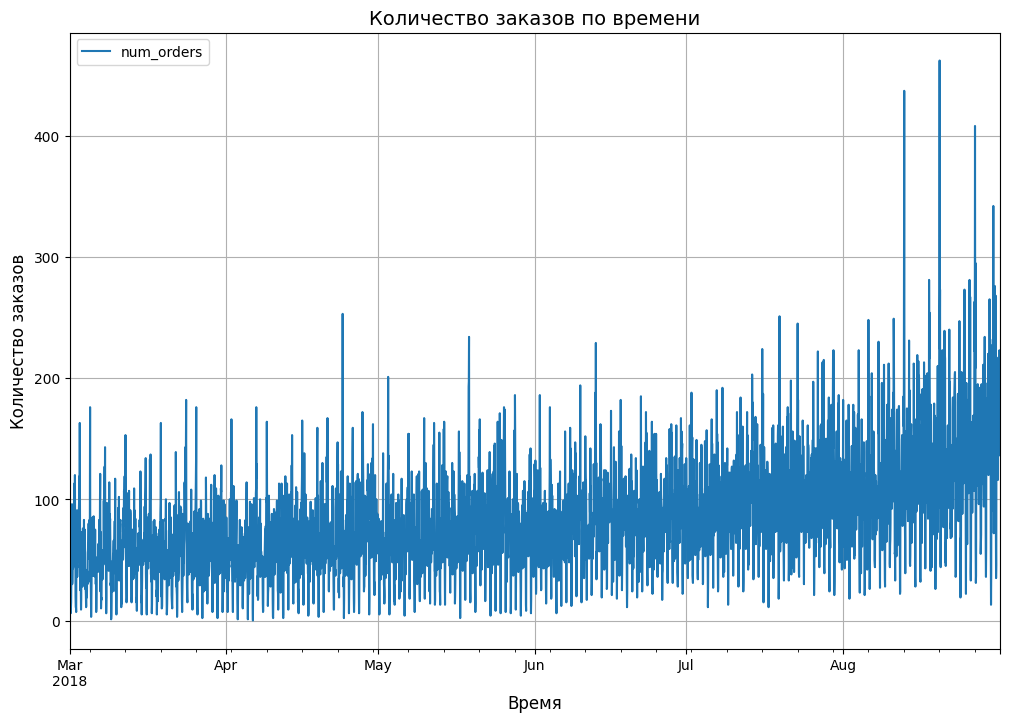

In [13]:
ax = data.plot(figsize=(12, 8))

ax.set_xlabel("Время", fontsize=12)
ax.set_ylabel("Количество заказов", fontsize=12)

ax.set_title("Количество заказов по времени", fontsize=14)

ax.grid(True)

plt.show()

График вышел слабо читаемым, чтобы это исправить строю новый график со скользящим средним

### Скользящее среднее

In [14]:
data['rolling_mean'] = data.rolling(24).mean()

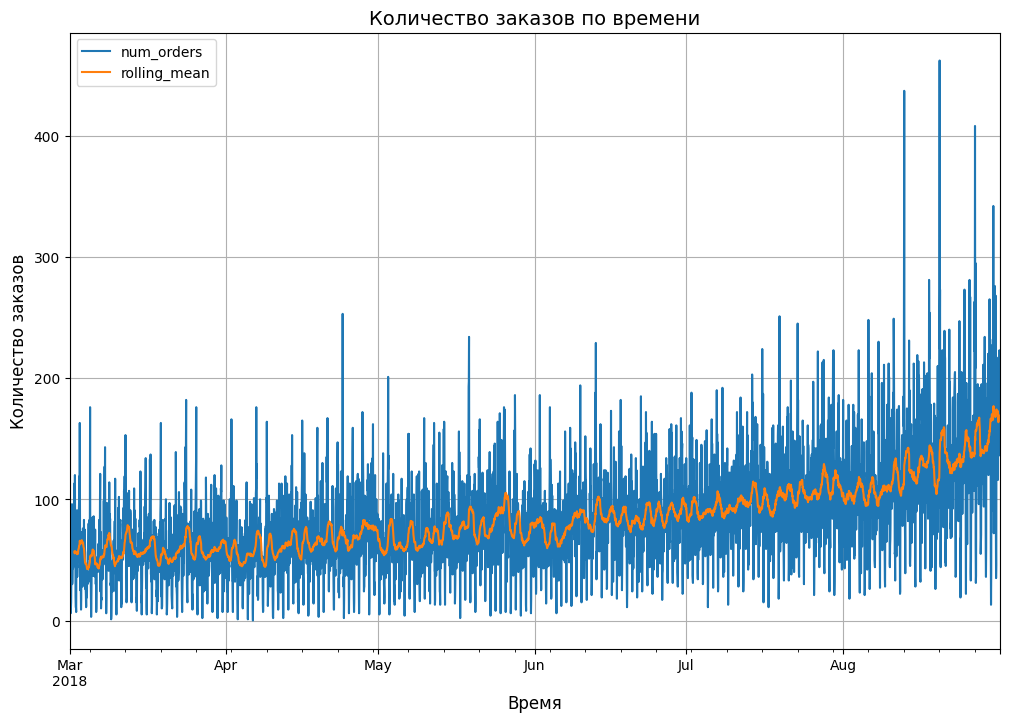

In [15]:
ax = data.plot(figsize=(12, 8))

ax.set_xlabel("Время", fontsize=12)
ax.set_ylabel("Количество заказов", fontsize=12)

ax.set_title("Количество заказов по времени", fontsize=14)

ax.grid(True)

plt.show()

Сейчас на графике видно, что среднее количество заказов плавно возрастает, самые большие значения среднего были в конце августа

### Тренды и сезонность

Выполняю декомпозицию по тренду и сезонности

In [16]:
data_clean = data.drop('rolling_mean', axis=1)
decomposed = seasonal_decompose(data_clean)

Строю графики

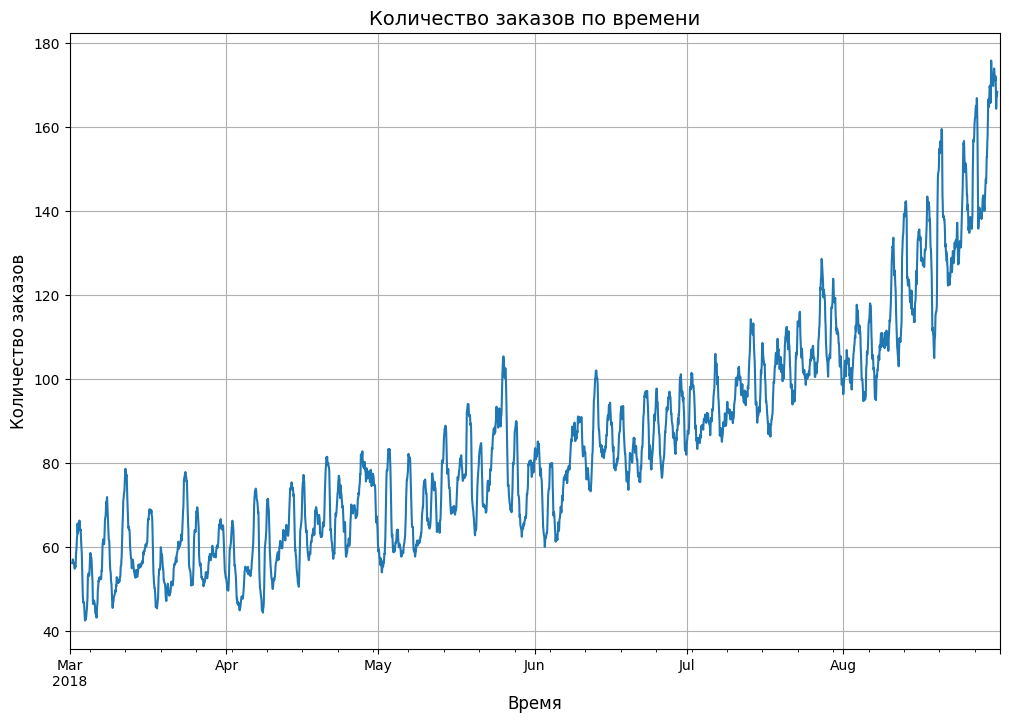

In [17]:
ax = decomposed.trend.plot(figsize=(12, 8))

ax.set_xlabel("Время", fontsize=12)
ax.set_ylabel("Количество заказов", fontsize=12)

ax.set_title("Количество заказов по времени", fontsize=14)

ax.grid(True)

plt.show()

Тренд явно указывает на увеличение количества заказов с каждым месяцем, т.к. данные собраны не за год, то сложно отследить точную закономерность, но можно предположить, что большая часть людей возвращается с отпусков и поездок в конце лета, с этим и связано повышение спроса на такси из аэропорта

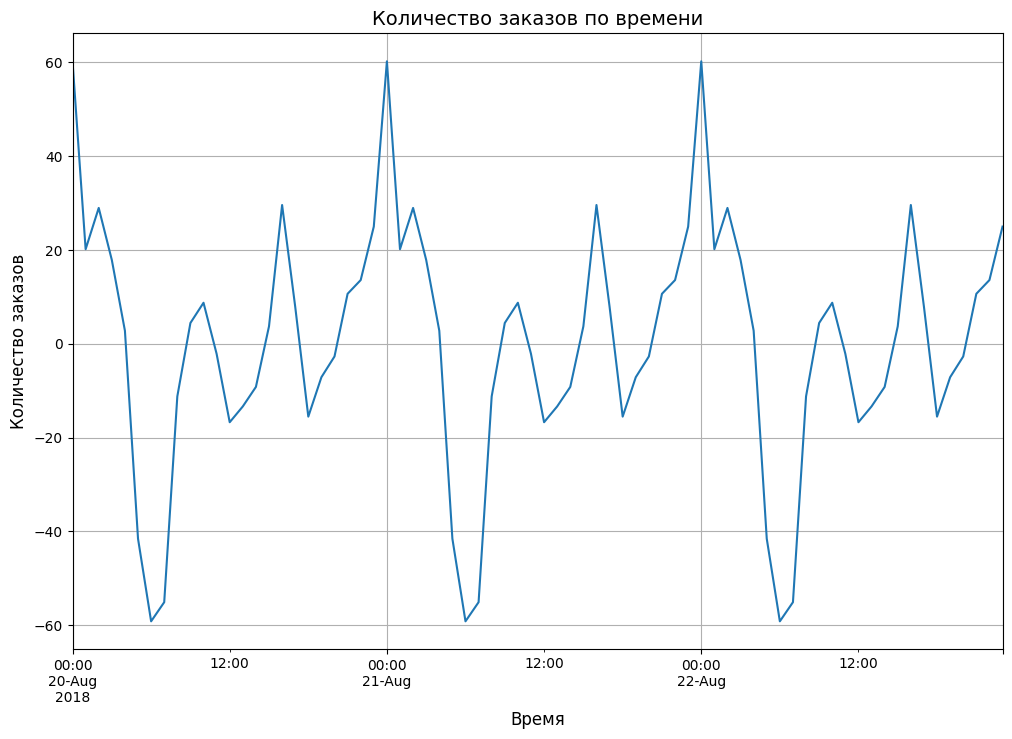

In [18]:
ax = decomposed.seasonal['2018-08-20':'2018-08-22'].plot(figsize=(12, 8))

ax.set_xlabel("Время", fontsize=12)
ax.set_ylabel("Количество заказов", fontsize=12)

ax.set_title("Количество заказов по времени", fontsize=14)

ax.grid(True)

plt.show()

График сезонности за 2 дня указывает на то, что такси чаще всего вызывают ближе к полуночи. Это может быть связано с тем, что общественный транспорт в эти часы уже не ходит. Так же есть пики после обеда и около полудня, скорее всего в эти часы прилетает большое количество людей

## Обучение

### Добавление новых признаков

Прописываю функцию для добавления новых признаков в данные

In [19]:
def make_features(data, max_lag, rolling_mean_size):

    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


Добавляю новые признаки

In [20]:
make_features(data, 24, 24)

In [21]:
data.head()

,num_orders,rolling_mean,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,4,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Подготовка данных

Подготавливаю данные для обучения, удаляю строки с пропущенными значениями из тренировочной выборки

In [22]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']


In [23]:
lag_columns = [col for col in X_train.columns if col.startswith('lag_')]
num_columns = ['rolling_mean'] + lag_columns
ohe_columns = ['hour', 'dayofweek']

In [24]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [25]:
data_preprocessor = ColumnTransformer(
    [
     ('ohe', ohe_pipe, ohe_columns),
     ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [26]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [27]:
param_grid = [
    {
        'models': [LGBMRegressor(verbose=-1)],
        'models__max_depth': [2, 4, 7, 1],
        'models__n_estimators': [100, 200, 300],
        'preprocessor__num': ['passthrough']
    },

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

    {
        'models': [CatBoostRegressor(verbose=0)],
        'models__iterations': [300, 500],
        'models__depth': [4, 6, 8],
        'preprocessor__num': ['passthrough']
    }
]

In [28]:
grid_search = GridSearchCV(
    estimator=pipe_final,
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


,estimator,Pipeline(step...egression())])
,param_grid,"[{'models': [LGBMRegressor(verbose=-1)], 'models__max_depth': [2, 4, ...], 'models__n_estimators': [100, 200, ...], 'preprocessor__num': ['passthrough']}, {'models': [LinearRegression()], 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, ...]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ohe', ...), ('num', ...)]"


In [29]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['hour', 'dayofweek']),
                                                 ('num', 'passthrough',
                                                  ['rolling_mean', 'lag_1',
                  

По итогу подбора лучшей моделью оказалася CatBoostRegressor

## Тестирование

In [30]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y_test, y_pred)}')

Метрика RMSE на тестовой выборке: 40.61998286552021


Метрика на лучшей модели вышла 40

### Проверка модели

Провожу проверку модели с использованием бейзлайнов и предсказания предыдущим значением

In [31]:
test_data = pd.DataFrame(index=X_test.index)
test_data['num_orders'] = y_test

In [32]:
test_data['pred_naive'] = test_data['num_orders'].shift(1)
test_data['pred_hourly'] = test_data['num_orders'].shift(24)
test_data['pred_weekly'] = test_data['num_orders'].shift(168)

In [33]:
test_data_clean = test_data.dropna()

In [34]:
print(f"RMSE предыдущее значение ряда: {root_mean_squared_error(test_data_clean['num_orders'], test_data_clean['pred_naive'])}")
print(f"RMSE часовой: {root_mean_squared_error(test_data_clean['num_orders'], test_data_clean['pred_hourly'])}")
print(f"RMSE недельный: {root_mean_squared_error(test_data_clean['num_orders'], test_data_clean['pred_weekly'])}")

RMSE предыдущее значение ряда: 59.993278212287535
RMSE часовой: 56.713005241334635
RMSE недельный: 42.03174851480341


По итогам проверки модель справляется лучше простых предсказаний. Хотя недельное предсказание вышло довольно близким по RMSE, но точность модели остается самой высокой

## Вывод

Такси чаще вызывают из аэропорта к концу лета, что скорее всего связано с возвращением людей из отпусков и поездок. Пиковые часы для таксистов около полуночи, в это время уже не ходит общественный транспорт и такси становиться чуть ли не единственным вариантом уехать из аэропорта. Эти факторы стоит учитывать в работе. Так же нужно собрать данные за целый год, чтобы проще было прогнозировать спрос на такси.